### Part 2. Model Implementation

Constrained Portfolio Liquidation Model

In [4]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

class PortfolioLiquidation:
    def __init__(self, q, gamma, T, N, X0, rho_t):
        self.q = q  # constant height of LOB
        self.gamma = gamma  # fraction of permanent impact
        self.T = T  # time period for execution
        self.N = N  # number of trading intervals
        self.X0 = X0  # total shares to buy
        self.rho_t = rho_t  # time dependent resilience rate
        self.t = np.linspace(0, T, N + 1)  # time intervals

    # function to calculate exponential recovery factor
    def recovery_factor(self):
        return np.exp(-np.cumsum(self.rho_t) * (self.t[1] - self.t[0]))

    # define the Cost Function
    def cost_function(self, x):
        impact = np.zeros_like(x)
        cumulative_order = 0
        # x is the array of order sizes
        for i in range(len(x)):
            cumulative_order += x[i]
            impact[i] = (self.gamma * cumulative_order +
                         (1/self.q - self.gamma) * np.sum(x[:i+1] * self.recovery_factor()[:i+1]))

        cost = np.sum(impact * x)
        return cost

    # constraint: sum of all orders should be equal to X0
    def total_order_constraint(self, x):
        return np.sum(x) - self.X0

    # minimize the cost function
    def optimize(self):
        bounds = [(0, self.X0) for _ in range(self.N)]
        constraints = [{'type': 'eq', 'fun': self.total_order_constraint}]
        x0 = np.full(self.N, self.X0 / self.N)

        result = opt.minimize(self.cost_function, x0, bounds=bounds, constraints=constraints)
        self.optimal_orders = result.x
        return self.optimal_orders

    # plot results
    def plot_results(self):
        plt.plot(self.t[:-1], self.optimal_orders, marker='o')
        plt.xlabel('Time')
        plt.ylabel('Order Size')
        plt.title('Optimal Order Sizes Over Time')
        plt.grid(True)
        plt.show()

    def print_results(self):
        print("Optimal Orders: ", self.optimal_orders)


testing with example input

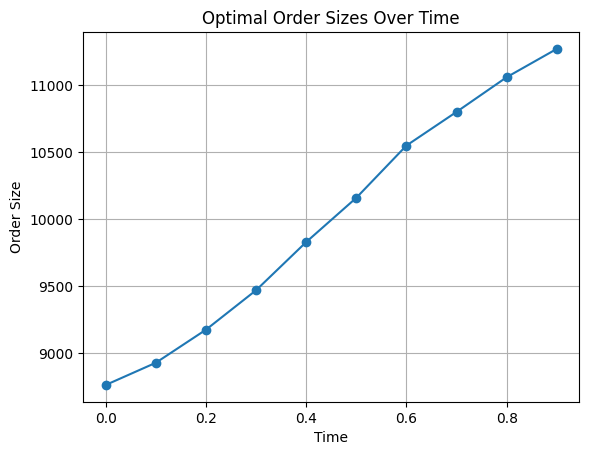

Optimal Orders:  [ 8761.63265294  8927.48966087  9174.3248718   9469.03804904
  9828.73169699 10159.12700183 10549.04915939 10800.51966439
 11059.33120153 11270.75604121]


In [5]:
q = 1  # constant height of LOB
gamma = 0.1  # fraction of permanent impact
T = 1  # time period for execution
N = 10  # number of trading intervals
X0 = 100000  # total shares to buy
rho_t = np.linspace(0.01, 0.1, N)  # time dependent resilience rate

liquidation_model = PortfolioLiquidation(q, gamma, T, N, X0, rho_t)
optimal_orders = liquidation_model.optimize()
liquidation_model.plot_results()
liquidation_model.print_results()

Market Impact Model

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class MarketImpactModel:
    def __init__(self, transactions, initial_price, spread, total_market_volume):
        self.transactions = transactions
        self.initial_price = initial_price
        self.spread = spread
        self.total_market_volume = total_market_volume

    # calculate the total signed volume of transactions.
    def calculate_volume(self):
        return np.sum(self.transactions['signed_volume'])

    # calculate volume fraction of market orders
    def calculate_volume_fraction_market_orders(self):
        total_volume = self.calculate_volume()
        market_order_volume = np.sum(self.transactions[self.transactions['order_type'] == 'market']['signed_volume'])
        return market_order_volume / total_volume if total_volume != 0 else 0

    # calculate the fraction of the total volume that is from market orders.
    def calculate_participation_rate(self):
        order_volume = self.calculate_volume()
        return order_volume / self.total_market_volume if self.total_market_volume != 0 else 0

    # calculate the market impact based on the log price change and spread.
    def calculate_market_impact(self):
        final_price = self.transactions.iloc[-1]['price']
        log_price_change = np.log(final_price / self.initial_price)
        return log_price_change / self.spread

    # calculate the market impact as a function of order size.
    def market_impact_order_size(self, order_size, A, delta):
        return A * (order_size ** delta)

    # calculate the impact over time based on the given beta.
    def impact_over_time(self, T, beta):
        t = np.arange(1, T + 1)
        return (t / T) ** beta

    # plot the impact over time
    def plot_impact_over_time(self, T, beta):
        impact_time = self.impact_over_time(T, beta)
        plt.plot(np.arange(1, T + 1), impact_time)
        plt.xlabel('Time')
        plt.ylabel('Impact')
        plt.title('Impact Over Time')
        plt.show()

testing with example inputs

Total Volume: 300
Volume Fraction of Market Orders: 0.67
Participation Rate: 0.03
Market Impact (Rescaled): 0.4939
Market Impact (Order Size): 8.6603


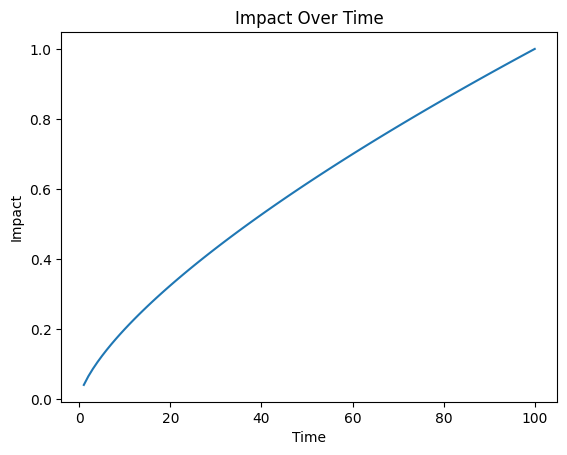

In [11]:
transactions = pd.DataFrame({
    'signed_volume': [100, 200, -150, 250, -100],  # signed volumes
    'order_type': ['market', 'limit', 'market', 'market', 'limit'],  # order types
    'price': [10.0, 10.2, 10.15, 10.3, 10.25]  # prices at each transaction
})

# initial price and spread
initial_price = transactions.iloc[0]['price']
spread = 0.05
total_market_volume = 10000  # total market volume

model = MarketImpactModel(transactions, initial_price, spread, total_market_volume)

# calculate and print metrics
volume = model.calculate_volume()
print(f"Total Volume: {volume}")

volume_fraction_market_orders = model.calculate_volume_fraction_market_orders()
print(f"Volume Fraction of Market Orders: {volume_fraction_market_orders:.2f}")

participation_rate = model.calculate_participation_rate()
print(f"Participation Rate: {participation_rate:.2f}")

market_impact = model.calculate_market_impact()
print(f"Market Impact (Rescaled): {market_impact:.4f}")

# market impact as a function of order size
A = 0.5
delta = 0.5
order_size = volume
impact_size = model.market_impact_order_size(order_size, A, delta)
print(f"Market Impact (Order Size): {impact_size:.4f}")

# plot impact over time
T = 100  # Total time
beta = 0.7
model.plot_impact_over_time(T, beta)